# Deep Learning Model: CNN - More Features
## Business Problem
Leukemia is a type of cancer of the blood that often affects young people. In the past, pathologists would diagnose patients by eye after examining blood smear images under the microscope. But, this is time consuming and tedious. Advances in image recognition technology have come a long ways since their inception. Therefore, automated solutions using computers would be of great benefit to the medical community to aid in cancer diagnoses.

The goal of this project is to address the following question: How can the doctor’s at the Munich University Hospital automate the diagnosis of patients with leukemia using images from blood smears?

## Approach
In the first deep learning notebook, I discovered that the model was not able to learn anything useful from the training data. To address this issue, I will try training the model on larger images. Instead of using the images rescaled by 12%, I will use the images rescaled by 25%. This will give the neural network more features to work with and could help improve its performance.

In [1]:
import sys
sys.path.append('..')
from time import time

from keras import layers
from keras import metrics
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from src.data_setup import make_dataset as md
from src.modeling import evaluate_model as em

%matplotlib inline

## Load Data
Load the pickled training and test data.

In [2]:
X_train, X_test, y_train, y_test = md.load_train_test('gray_rescale25')

In [3]:
X_train.shape

(14692, 10000)

In [4]:
pd.Series(y_train).value_counts()

NGS    6787
LYT    3150
MYO    2615
MON    1431
EOS     339
NGB      87
BAS      63
EBO      62
PMO      56
MYB      34
MOB      21
PMB      14
MMZ      12
KSC      12
LYA       9
dtype: int64

In [5]:
pd.Series(y_test).value_counts()

NGS    1697
LYT     787
MYO     653
MON     358
EOS      85
NGB      22
EBO      16
BAS      16
PMO      14
MYB       8
MOB       5
PMB       4
MMZ       3
KSC       3
LYA       2
dtype: int64

## Data Preparation
### Unflatten
Unflatten the feature arrays, converting them back into arrays of 2-dimensional images.

In [6]:
def unflatten(X):
    dimension = int(np.sqrt(X.shape[1]))
    return X.reshape((len(X), dimension, dimension, 1))

In [7]:
X_train_unflatten = unflatten(X_train)
X_train_unflatten.shape

(14692, 100, 100, 1)

In [8]:
X_test_unflatten = unflatten(X_test)
X_test_unflatten.shape

(3673, 100, 100, 1)

### Normalize
Normalize the features, to values between 0 and 1.

In [9]:
print(f'The maximum value for the training set is {X_train_unflatten.max()}.')
print(f'The maximum value for the test set is {X_test_unflatten.max()}.')

The maximum value for the training set is 255.
The maximum value for the test set is 255.


In [10]:
X_train_normalized = X_train_unflatten / X_train_unflatten.max()
X_test_normalized = X_test_unflatten / X_test_unflatten.max()

In [11]:
print(f'The maximum value for the normalized training set is {X_train_normalized.max()}.')
print(f'The maximum value for the normalized test set is {X_test_normalized.max()}.')

The maximum value for the normalized training set is 1.0.
The maximum value for the normalized test set is 1.0.


### Categories
First, encode the labels to integer values.

In [12]:
label_encodings = {value: i for i, value in enumerate(np.unique(y_train))}

In [13]:
label_encodings

{'BAS': 0,
 'EBO': 1,
 'EOS': 2,
 'KSC': 3,
 'LYA': 4,
 'LYT': 5,
 'MMZ': 6,
 'MOB': 7,
 'MON': 8,
 'MYB': 9,
 'MYO': 10,
 'NGB': 11,
 'NGS': 12,
 'PMB': 13,
 'PMO': 14}

In [14]:
pd.Series(y_train).value_counts()

NGS    6787
LYT    3150
MYO    2615
MON    1431
EOS     339
NGB      87
BAS      63
EBO      62
PMO      56
MYB      34
MOB      21
PMB      14
MMZ      12
KSC      12
LYA       9
dtype: int64

In [15]:
y_train_encoded = pd.Series(y_train).replace(label_encodings).values
y_test_encoded = pd.Series(y_test).replace(label_encodings).values

In [16]:
np.unique(y_train_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [17]:
np.unique(y_test_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

Second, encode the integer labels as one-hot vectors.

In [18]:
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [19]:
y_train_one_hot.shape

(14692, 15)

In [20]:
y_train_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

In [21]:
y_test_one_hot.shape

(3673, 15)

In [22]:
y_test_one_hot[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

## Validation Set
Now that we have preprocessed the training data, I will create a validation set. This will be used to evaluate how the deep learning model is training.

In [23]:
X_train_normalized, X_val, y_train_one_hot, y_val = train_test_split(X_train_normalized, y_train_one_hot, test_size=0.1, random_state=42)

## Define Model

In [24]:
input_shape = X_train_unflatten.shape[1:]
print(f'The input shape is {input_shape}.')

The input shape is (100, 100, 1).


In [25]:
model_1 = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Conv2D(16, kernel_size=(7, 7), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(38, activation='relu'),
    layers.Dense(15, activation='softmax')
])

In [26]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        6288      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)              0         
_________________________________________________________________
dense (Dense)                (None, 600)               4647000   
_________________________________________________________________
dense_1 (Dense)              (None, 150)               9

### Train Model
Create class weights to counter class imbalance.

In [27]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

In [28]:
class_weights_dict

{0: 15.547089947089948,
 1: 15.79784946236559,
 2: 2.889282202556539,
 3: 81.62222222222222,
 4: 108.82962962962964,
 5: 0.31094179894179896,
 6: 81.62222222222222,
 7: 46.64126984126984,
 8: 0.6844630794316329,
 9: 28.807843137254903,
 10: 0.3745570427023582,
 11: 11.25823754789272,
 12: 0.14431511222435048,
 13: 69.96190476190476,
 14: 17.49047619047619}

In [29]:
model_1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=[
                    metrics.Accuracy(),
                    metrics.categorical_accuracy,
                    metrics.Precision(),
                    metrics.Recall()
                ])
results_3 = model_1.fit(X_train_normalized, y_train_one_hot, validation_data=(X_val, y_val), epochs=50, batch_size=64, class_weight=class_weights_dict)

Epoch 1/50
207/207 [==============================] - 30s 141ms/step - loss: 3.4153 - accuracy: 0.0000e+00 - categorical_accuracy: 0.2480 - precision: 0.2955 - recall: 0.0159 - val_loss: 1.7905 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.6327 - val_precision: 0.9882 - val_recall: 0.1714
Epoch 2/50
207/207 [==============================] - 29s 138ms/step - loss: 2.7030 - accuracy: 3.8583e-06 - categorical_accuracy: 0.5611 - precision: 0.9219 - recall: 0.2075 - val_loss: 1.7670 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.3952 - val_precision: 0.5246 - val_recall: 0.0653
Epoch 3/50
207/207 [==============================] - 27s 131ms/step - loss: 2.3673 - accuracy: 0.0000e+00 - categorical_accuracy: 0.4748 - precision: 0.7294 - recall: 0.2387 - val_loss: 1.5166 - val_accuracy: 0.0000e+00 - val_categorical_accuracy: 0.4741 - val_precision: 0.9217 - val_recall: 0.2483
Epoch 4/50
207/207 [==============================] - 28s 136ms/step - loss: 2.0720 - accuracy: 1

In [30]:
results_3.history.keys()

dict_keys(['loss', 'accuracy', 'categorical_accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_categorical_accuracy', 'val_precision', 'val_recall'])

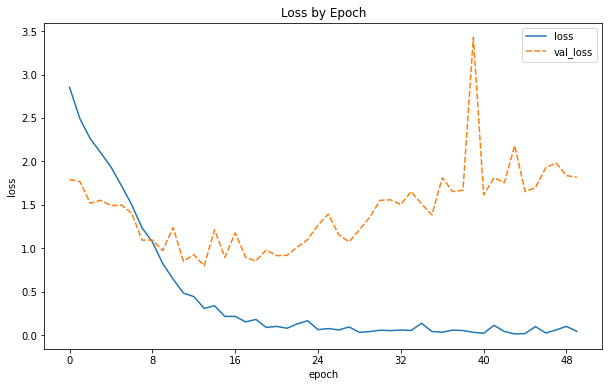

In [31]:
em.plot_train_val_losses(results_3)

**Observations:**
The large gap between the training loss and validation loss indicates that the training data still does not provide sufficient information to fit the model properly.